## Setup and Data Loading

In [6]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Add parent directory to path
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

In [7]:
from src.kaggle_utils import download_competition

data_dir = download_competition("playground-series-s5e11")
data_dir

PosixPath('/Users/boris.tsarev/MyProjects/kaggle-competitions/data/raw/playground-series-s5e11')

In [54]:
# Load data
train = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (593994, 13)
Test shape: (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## Data Preprocessing

In [47]:
# Define feature groups
cats = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
conts = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
dep = 'loan_paid_back'

def proc_data(df):
    """Process categorical variables and apply log transformation to skewed features"""
    # Encode categorical variables
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    
    # Log transform skewed features
    df['loan_amount'] = np.log1p(df['loan_amount'])
    df['annual_income'] = np.log1p(df['annual_income'])
    
    return df

In [69]:
# Create train/validation split
train_df, valid_df = train_test_split(train, test_size=0.2)

def process_all_data():
    global train_X, train_y, valid_X, valid_y, test_X, test_proc

    train_proc = train_df.copy()
    train_proc = proc_data(train_proc)

    valid_proc = valid_df.copy()
    valid_proc = proc_data(valid_proc)

    test_proc = test.copy()
    test_proc = proc_data(test_proc)

    # Prepare feature matrices
    train_X = train_proc.drop(columns=[dep, 'id'])
    train_y = train_proc[dep]

    valid_X = valid_proc.drop(columns=[dep, 'id'])
    valid_y = valid_proc[dep]

    test_X = test_proc.drop(columns=['id'])

process_all_data()
valid_X.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,employment_status,grade_subgrade,debt,loan_income_ratio
431193,11.210128,0.240,677,6.357600,16.73,0,0,12,2.690431,0.567130
132993,11.704933,0.034,607,8.888757,12.99,1,0,22,0.397968,0.759403
318164,9.645048,0.177,733,9.615103,9.00,0,0,11,1.707174,0.996895
546831,10.504467,0.198,722,9.864149,11.42,1,3,13,2.079885,0.939043
260928,9.798979,0.186,690,10.216143,12.52,1,0,10,1.822610,1.042572


## Model Training

In [63]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, max_features=8, max_depth=10, n_jobs=-1)

def evaluate_forest():
    rf.fit(train_X, train_y)
    valid_preds = rf.predict_proba(valid_X)[:, 1]
    roc_score = roc_auc_score(valid_y, valid_preds)
    print(f"Validation ROC AUC: {roc_score:.5f}")

evaluate_forest()

Validation ROC AUC: 0.91525


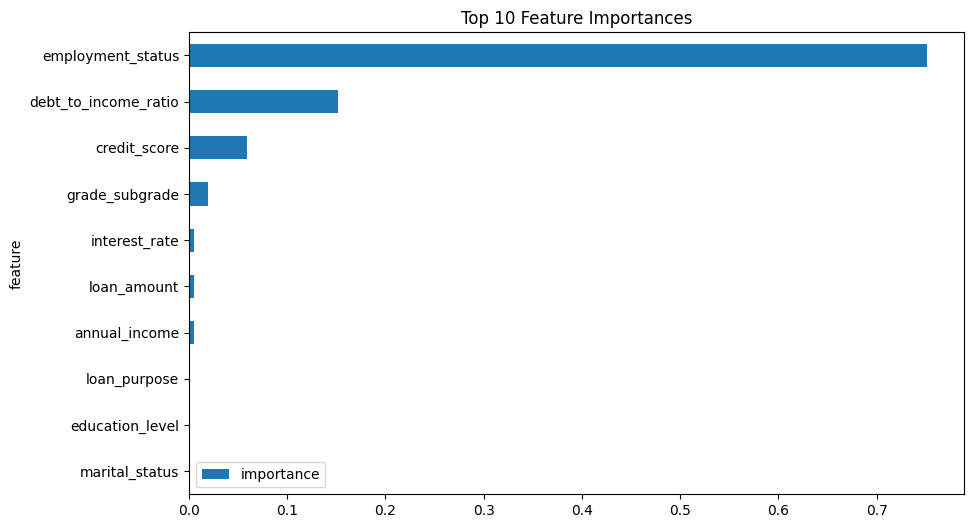

In [64]:
def show_feature_importance(top_n=None):
    feature_imp = pd.DataFrame({
        'feature': train_X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    if top_n:
        feature_imp = feature_imp.head(top_n)
    
    feature_imp = feature_imp.sort_values('importance', ascending=True)
    
    title = f'Top {top_n} Feature Importances' if top_n else 'Feature Importances'
    feature_imp.plot(x='feature', y='importance', kind='barh', figsize=(10, 6), title=title)

show_feature_importance(10)

## Submission

In [13]:
def create_submission(model, test_X, test_ids, filename):
    """Generate predictions and create submission file"""
    preds = model.predict_proba(test_X)[:, 1]
    submission = pd.DataFrame({
        'id': test_ids,
        'loan_paid_back': preds
    })
    
    output_dir = Path("playground-series-s5e11_2")
    output_dir.mkdir(exist_ok=True)
    
    filepath = output_dir / filename
    submission.to_csv(filepath, index=False)
    print(f"Submission saved to {filepath}")
    return submission

In [14]:
# Create submission
submission = create_submission(rf, test_X, test_proc['id'], 'submission_baseline.csv')
submission.head()

Submission saved to playground-series-s5e11_2/submission_baseline.csv


,id,loan_paid_back
0,593994,0.927543
1,593995,0.990238
2,593996,0.421725
3,593997,0.957032
4,593998,0.922545


# Data engineering

Try some new features

In [71]:
def proc_data(df):
    """Process categorical variables and apply log transformation to skewed features"""
    # Encode categorical variables
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    
    # Log transform skewed features
    df['loan_amount'] = np.log1p(df['loan_amount'])
    df['annual_income'] = np.log1p(df['annual_income'])
    df['debt'] = df['debt_to_income_ratio'] * df['annual_income']
    df['loan_income_ratio'] = df['loan_amount'] / df['annual_income']
    
    return df

process_all_data()
evaluate_forest()

Validation ROC AUC: 0.91287


In [ ]:
# it's a bit better, submit
submission = create_submission(rf, test_X, test_proc['id'], 'forest-3.csv')

Submission saved to playground-series-s5e11_2/forest-3.csv


Try polynomial features

Validation ROC AUC: 0.91261


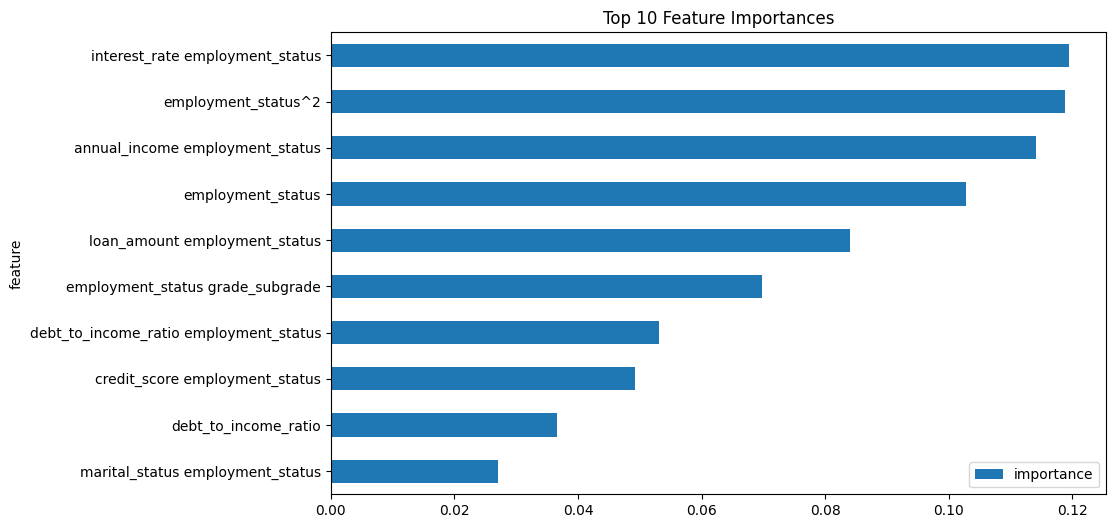

In [67]:
from sklearn.preprocessing import PolynomialFeatures

def proc_data(df):
    """Process categorical variables and apply log transformation to skewed features"""
    # Encode categorical variables
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    
    # Log transform skewed features
    df['loan_amount'] = np.log1p(df['loan_amount'])
    df['annual_income'] = np.log1p(df['annual_income'])
    
    return df

process_all_data()

poly = PolynomialFeatures(degree=2, include_bias=False)

# FIT on train, TRANSFORM on all
train_X_poly = poly.fit_transform(train_X)
valid_X_poly = poly.transform(valid_X)  # Use transform, not fit_transform!
test_X_poly = poly.transform(test_X)

# Convert back to DataFrame (optional, for feature names)
feature_names = poly.get_feature_names_out(train_X.columns)
train_X = pd.DataFrame(train_X_poly, columns=feature_names, index=train_X.index)
valid_X = pd.DataFrame(valid_X_poly, columns=feature_names, index=valid_X.index)
test_X = pd.DataFrame(test_X_poly, columns=feature_names, index=test_X.index)

evaluate_forest()
show_feature_importance(10)

Didn't get better with polynomial

Try removing unimportant features

In [70]:
def proc_data(df):
    """Process categorical variables and apply log transformation to skewed features"""
    # Encode categorical variables
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    
    # Log transform skewed features
    df['loan_amount'] = np.log1p(df['loan_amount'])
    df['annual_income'] = np.log1p(df['annual_income'])
    df['debt'] = df['debt_to_income_ratio'] * df['annual_income']
    df['loan_income_ratio'] = df['loan_amount'] / df['annual_income']
    df = df.drop(columns=['loan_purpose', 'marital_status', 'education_level'])
    
    return df

process_all_data()
evaluate_forest()

Validation ROC AUC: 0.91351


More or less the same